# Metropolis-Hastings Markov Chain Monte Carlo

In [1]:
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import functools
import pdb

First example found here: https://arxiv.org/pdf/1504.01896.pdf

In [6]:
def sinus_normal(x):
    return np.sin(x)**2 * np.sin(2*x)**2 * sp.norm.pdf(x)

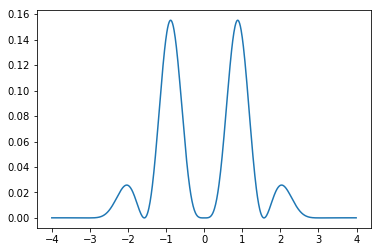

In [15]:
test = [sinus_normal(x) for x in np.arange(-4.,4.,0.01)]
plt.plot(np.arange(-4.,4.,0.01), test)
plt.show()

**Why does the Metropolis(-Hastings) algorithm work for our posterior distribution?**

The problem with the posterior distribution is that the denominator is hard to calculate (or *intractable*). Fortunately for us, the idea of the Metropolis sampling is to jump to a proposed value $x'$ if the *relative* density at that point is higher. That means that we evaluate $P(x'|D)/P(x|D)$. Remember that $P(x|D) = \frac{P(D|x) P(x)}{P(D)}$, where the part $P(D)$ is intractable. For the ratio, we calculate 

$$ \frac{ 
\frac{P(D|x') P(x')}{P(D)}}{
\frac{P(D|x) P(x)}{P(D)}
} = \frac{ 
P(D|x') P(x')}{
P(D|x) P(x)
}.$$

The complicated part $P(D)$ drops out, because it is the same for any parameter choice of our model and we can sample as much as we want without having to calculate it.

In [92]:
def metropolis(start_value, n_iter, density, proposal_distribution):
    chain = np.zeros([n_iter])
    chain_acceptance_ratio = np.zeros([n_iter])
    
    x = start_value
    x_density = density(x)
    chain[0] = x
    
    for i in range(1,n_iter):
        candidate_x = np.float64(proposal_distribution(x)) # naturally handle /0
        candidate_x_density = np.float64(density(candidate_x))
        
        acceptance_ratio = candidate_x_density/x_density
        if np.isnan(acceptance_ratio):
            acceptance_ratio = 0.
        acceptance_ratio = min(acceptance_ratio, 1)
        
        random_u = np.random.uniform(0,1)
        if random_u <= acceptance_ratio:
            x = candidate_x
            x_density = candidate_x_density
        
        chain[i] = x
        chain_acceptance_ratio[i] = acceptance_ratio
    
    return chain,chain_acceptance_ratio

We have a way to evaluate a proposal by the acceptance ratio, but we haven't defined a way to pick a candidate $x'$ yet. This choice is important. 

If we jump to much between candidates, e.g. from 1 to 100, the chance is high that we end up in areas with low probability density and won't accept the proposal. If we jump too little, e.g. from 1 to 1.005, we will have to jump many times to explore the full range between -4 and 4.

A good proposal distribution generates a random walk by jumping from the last point in the chain and has a jump size that leads to an acceptance rate that is not too high and not too low. 

TODO: Roberts et al. (1997) suggest that for a Gaussian proposal distribution the optimal acceptance rate should be 0.25. 
*Roberts, G., Gelman, A., and Gilks, W. (1997). “Weak convergence and optimal scaling of
random walk Metropolis algorithms.” Ann. Applied Prob., 7: 110–120.*

In [122]:
def normal_proposal(x):
    return np.random.normal(x, 1) # The precision defines the jump size

In [100]:
test,alpha = metropolis(0, 10000, sinus_normal, normal_proposal)

/Users/maj/anaconda/envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


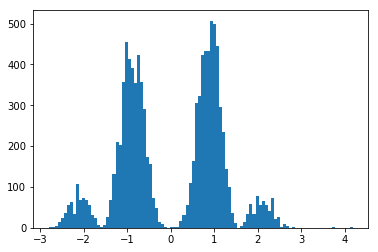

In [104]:
plt.hist(test, bins=100)
plt.show()

**What happens if we pick a start value that's completely off?**

As long as the proposal distribution has a reasonable chance to jump to a point with density above zero, then the chain will eventually reach the interesting part of the distribution and explore it. Since the path to the areas with the highest density may take some iterations, it is common practice to drop the first *n* observations, which are called *burn-in*.

In [118]:
test,alpha = metropolis(10, 10000, sinus_normal, normal_proposal)

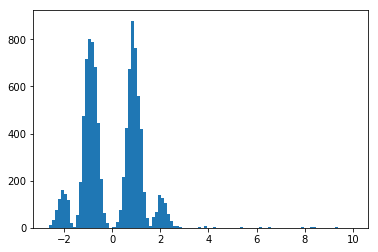

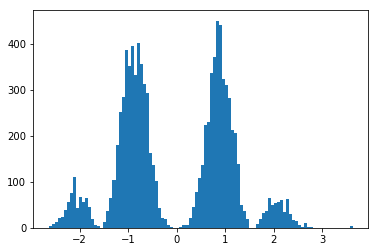

In [121]:
plt.hist(test, bins=100) # Start value off, no burn-in
plt.show()
plt.hist(test[500:], bins=100) # With a burn-in of 500
plt.show()

TODO: Extend to Metropolis Hastings by including the ratio q(x|y)/q(y|x) to correct for asymmetric proposal distributions

TODO: Look at autocorrelation and explain effective sample size 

## Regression example

In [233]:
def generate_data(n, beta, sigma2):
    X = np.random.normal(0,2,size=[n, len(beta)])
    y = np.dot(X,beta) + np.random.normal(0, sigma2)
    return X, y

In [234]:
X_train, y_train = generate_data(5000, [-1, 1, 2], 1)

In [235]:
def regression_log_likelihood(y, X, beta, sigma2):
    log_likelihood_x = sp.norm.logpdf(y,  # True value
                loc=np.dot(X,beta), # Predicted value
                scale=sigma2 # Estimated error variance
                )          
                                      
    log_likelihood = np.sum(log_likelihood_x)
    return log_likelihood

regression_log_likelihood = functools.partial(regression_log_likelihood, y=y_train, X=X_train)

In [252]:
def regression_log_prior(beta,sigma2):
    beta_prior_probability = np.sum(sp.norm.logpdf(beta, 
                                            loc=[0]*len(beta), # Pull towards 0
                                            scale = [3]*len(beta)))
    # Gamma distribution is always positive
    #sigma_prior_probability = sp.gamma.logpdf(sigma2, a=1, scale=0.5)
    sigma_prior_probability = sp.truncnorm.logpdf(sigma2, a=0, b=np.inf, loc=0,scale=2)
    log_likelihood = np.sum([beta_prior_probability, sigma_prior_probability])
    return log_likelihood

In [258]:
def regression_proposal(beta, sigma2):
    beta = np.float64(np.random.normal(beta, 0.02))
    sigma2 = np.float64(np.random.normal(sigma2, 0.02))
    return beta,sigma2

In [259]:
def metropolis(start_value_beta, start_value_sigma2, 
               n_iter, likelihood_distribution, prior_distribution,proposal_distribution):
    chain = np.zeros([n_iter, len(start_value_beta)+len(start_value_sigma2)])
    chain_acceptance_ratio = np.zeros([n_iter])
    
    def posterior(beta, sigma2):
        log_likelihood = likelihood_distribution(beta=beta, sigma2=sigma2)
        log_prior = prior_distribution(beta,sigma2)
        log_posterior = np.sum([log_likelihood, log_prior])
        return log_posterior
    
    beta = start_value_beta
    sigma2 = start_value_sigma2
    current_posterior = posterior(beta=beta, sigma2=sigma2)
    chain[0,:] = np.concatenate([beta,sigma2])
    
    #pdb.set_trace()
    
    for i in range(1,n_iter):
        candidate_beta, candidate_sigma2 = proposal_distribution(beta,sigma2) # naturally handle /0
        candidate_posterior = posterior(beta=candidate_beta, sigma2=candidate_sigma2)
        
        # Careful here: 
        # ln(acc_ratio) = ln(post'/post) = ln_post - ln_post
        # -> acc_ratio = exp(ln_post' - ln_post)
        acceptance_ratio = np.exp(candidate_posterior - current_posterior)
        #if np.isnan(acceptance_ratio):
        #    acceptance_ratio = 0.
        acceptance_ratio = min(acceptance_ratio, 1)
        
        random_u = np.random.uniform(0,1)
        if random_u <= acceptance_ratio:
            beta, sigma2 = candidate_beta, candidate_sigma2
            current_posterior = candidate_posterior
        
        chain[i,:] = np.append(beta,sigma2)
        chain_acceptance_ratio[i] = acceptance_ratio
    
    return chain,chain_acceptance_ratio

In [260]:
test,alpha = metropolis([0,0,0], [0.2], 
                        n_iter = 20000, 
                        likelihood_distribution = regression_log_likelihood,
                        prior_distribution = regression_log_prior,
                        proposal_distribution = regression_proposal)

/Users/maj/anaconda/envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


In [261]:
np.mean(alpha)

0.14768272820292708

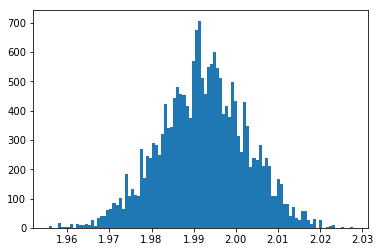

In [267]:
plt.hist(test[1000:,2], bins=100) # Start value off, no burn-in
plt.show()
#plt.hist(test[500:], bins=100) # With a burn-in of 500
#plt.show()

TODO: We seem to consistently and substantially overestimate the variance to 1.4 instead of 1. Why is that?